In [ ]:
TUGAS BESAR PROJECT DASAR KECERDASAN ARTIFICIAL

In [49]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [51]:
# Memasukkan dataset dan dibersihkan
df = pd.read_csv("hotel_bookings.csv")

# Drop data yang tidak ada nilai
df.dropna(inplace=True)

# Rename salah satu nama column untuk mempersingkat
df.rename(columns={'total_of_special_requests': 'special_requests'}, inplace=True)

# Clip outliers to fit our fuzzy universe
df['lead_time'] = df['lead_time'].clip(0, 500)
df['adr'] = df['adr'].clip(0, 400)
df['special_requests'] = df['special_requests'].clip(0, 5)
df['booking_changes'] = df['booking_changes'].clip(0, 10)

# Optional: Display summary
print(df.describe())

       is_canceled   lead_time  arrival_date_year  arrival_date_week_number  \
count   217.000000  217.000000         217.000000                217.000000   
mean      0.078341   40.520737        2015.465438                 38.198157   
std       0.269329   61.748375           0.720053                 12.890292   
min       0.000000    0.000000        2015.000000                  1.000000   
25%       0.000000   12.000000        2015.000000                 33.000000   
50%       0.000000   27.000000        2015.000000                 45.000000   
75%       0.000000   36.000000        2016.000000                 46.000000   
max       1.000000  364.000000        2017.000000                 53.000000   

       arrival_date_day_of_month  stays_in_weekend_nights  \
count                 217.000000                217.00000   
mean                   10.824885                  1.56682   
std                     7.582065                  1.49270   
min                     1.000000            

In [53]:
# Variable Fuzzy
#Input
lead_time = ctrl.Antecedent(np.arange(0, 501, 1), 'lead_time')
adr = ctrl.Antecedent(np.arange(0, 401, 1), 'adr')
special_requests = ctrl.Antecedent(np.arange(0, 6, 1), 'special_requests')
booking_changes = ctrl.Antecedent(np.arange(0, 11, 1), 'booking_changes')

#Output
cancellation_risk = ctrl.Consequent(np.arange(0, 101, 1), 'cancellation_risk')

In [55]:
# Definisi Membership Functions
lead_time['low'] = fuzz.trimf(lead_time.universe, [0, 0, 150])
lead_time['medium'] = fuzz.trimf(lead_time.universe, [100, 250, 400])
lead_time['high'] = fuzz.trimf(lead_time.universe, [300, 500, 500])

adr['low'] = fuzz.trimf(adr.universe, [0, 0, 100])
adr['medium'] = fuzz.trimf(adr.universe, [75, 150, 250])
adr['high'] = fuzz.trimf(adr.universe, [200, 400, 400])

special_requests['low'] = fuzz.trimf(special_requests.universe, [0, 0, 1])
special_requests['medium'] = fuzz.trimf(special_requests.universe, [1, 2, 3])
special_requests['high'] = fuzz.trimf(special_requests.universe, [2, 5, 5])

booking_changes['low'] = fuzz.trimf(booking_changes.universe, [0, 0, 2])
booking_changes['medium'] = fuzz.trimf(booking_changes.universe, [1, 3, 5])
booking_changes['high'] = fuzz.trimf(booking_changes.universe, [4, 10, 10])

cancellation_risk['low'] = fuzz.trimf(cancellation_risk.universe, [0, 0, 40])
cancellation_risk['medium'] = fuzz.trimf(cancellation_risk.universe, [30, 50, 70])
cancellation_risk['high'] = fuzz.trimf(cancellation_risk.universe, [60, 100, 100])

In [57]:
# Definisi Fuzzy Rule
rule1 = ctrl.Rule(lead_time['high'] & adr['high'], cancellation_risk['high'])
rule2 = ctrl.Rule(lead_time['low'] & special_requests['high'], cancellation_risk['low'])
rule3 = ctrl.Rule(booking_changes['high'], cancellation_risk['high'])
rule4 = ctrl.Rule(adr['low'] & booking_changes['low'], cancellation_risk['low'])
rule5 = ctrl.Rule(special_requests['low'] & lead_time['medium'], cancellation_risk['medium'])

In [59]:
# Membuat dan mensimulasikan System Control
risk_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
risk_sim = ctrl.ControlSystemSimulation(risk_ctrl)

In [130]:
# Simulasi dengan dataset
sample = df[['lead_time', 'adr', 'special_requests', 'booking_changes']].sample(1).iloc[0]
#.sample(1) untuk mengambil satu row random
#.iloc(0) untuk mengambil data secara serial (mengikuti parameter)

# Memasukkan nilai input
risk_sim.input['lead_time'] = sample['lead_time']
risk_sim.input['adr'] = sample['adr']
risk_sim.input['special_requests'] = sample['special_requests']
risk_sim.input['booking_changes'] = sample['booking_changes']

# Menghitung hasilnya
risk_sim.compute()

In [132]:
# Show Hasil 
print("Booking details:")
print(sample)
try:
    print(f"\nPredicted cancellation risk: {risk_sim.output['cancellation_risk']:.2f}%")
except Exception as e:
    print("Tidak bisa dihitung risikonya",e)

#Pakai try karena kadang adabeberapa variabel yang hilang atau diluar range, atau fuzzy rule nya tidak ke trigger

Booking details:
lead_time           28.0
adr                 40.0
special_requests     0.0
booking_changes      1.0
Name: 18211, dtype: float64

Predicted cancellation risk: 15.56%


/opt/anaconda3/lib/python3.12/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


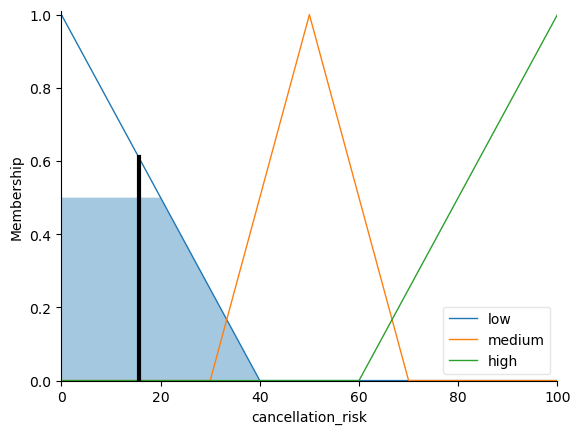

In [134]:
# Visualisasi
cancellation_risk.view(sim=risk_sim)